# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Mounted at /content/gdrive
gdrive	sample_data


# Libraries

In [ ]:
import os
import sys
import pickle

import time
import math
import copy

import wget

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic_2d
from scipy import stats

from astropy.io import fits
from astropy.wcs import WCS
from astropy    import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, join
import astropy.constants as const

import plotly.express as px
import plotly.graph_objects as go

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

import torch

from pathlib import Path

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
gaia_path = Path('/content/gdrive/MyDrive/Colab Notebooks/gaia/')
ml_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')
gaskap_path = Path('/content/gdrive/MyDrive/Colab Notebooks/GASKAP')

ml_data_path = ml_path / 'data'
data_path = gaia_path / 'data'
dust_data_path = data_path / 'edenhofer'
gaskap_data_path = gaskap_path / 'data'

local_bubble_data_path = data_path / 'oneill'

gaskap_hires_data_path = gaskap_data_path / 'hires'
gaskap_hires_result_path = gaskap_hires_data_path / 'results'

GASS_data_path = gaskap_data_path / 'GASS'

dynamics_file = data_path / 'galah_dr4_vac_dynamics_240705.fits'
allstar_file = data_path / 'galah_dr4_allstar_240705.fits'
gaia_catalog_file = data_path / 'stellar_params_catalog-1kpc.fits'
gaia_catalog_file = data_path / 'stars_MC_fg.fits'

# Read Galah data

In [ ]:
# For Doppler velocity (observed)
lambda_rest = 7698.9643 # Angstroms
c = const.c.to(u.km/u.s).value  # Speed of light in km/s
c

np.float64(299792.458)

In [ ]:
galah0 = Table.read(allstar_file)
# Limit GALAH data to measurements that actually have interstellar potassium (k_is) detected with an equivalent width &
# where we have distances 'r_med' to stars
med_dist_lim = 30_000. # pc
galah0 = galah0[np.isfinite(galah0['ew_k_is']) & np.isfinite(galah0['r_med']) & (galah0['r_med'] < med_dist_lim) ]

In [ ]:
galah_dynamics = Table.read(dynamics_file)
galah_dynamics = galah_dynamics[['tmass_id','V_UVW']]

# Join
galah0 = join(galah0, galah_dynamics, keys = 'tmass_id', metadata_conflicts='silent')

# Interstellar Material Maps: [270,310] [-46,-26]

In [ ]:
med_dist = galah0['r_med'].data
med_dist = np.array(med_dist, dtype='float32')

ra = galah0['ra'].data
dec = galah0['dec'].data

ew_k_is = galah0['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))


# convert RA and Dec into galactic l and b
coords = SkyCoord(ra=ra, dec=dec, unit='degree')
ra = coords.ra.wrap_at(180 * u.deg).radian
dec = coords.dec.radian
# l = coords.galactic.l.wrap_at(180 * u.deg).radian
# b = coords.galactic.b.radian

glon = coords.galactic.l.value
glat = coords.galactic.b.value

In [ ]:
galah0.add_columns([glon*u.deg, glat*u.deg], names=['l', 'b'])

In [ ]:
galah = galah0[(glon > lmc_glon[0]) & (glon < lmc_glon[1]) & (glat > -80.) & (glat < lmc_glat[1]) & (med_dist > 0.) & np.isfinite(galah0['age'])]

In [ ]:
galah_fg = galah0[(galah0['l'] > lmc_glon[0]) & (galah0['l'] < lmc_glon[1]-2) & (galah0['b'] > -47.) & (galah0['b'] < -27.5) & (galah0['r_med'] > 0.) & (np.log10(galah0['ew_k_is']) > -1.5) & (np.log10(galah0['ew_k_is']) < 0.4)]
galah_fg

sobject_id,tmass_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,flag_sp,flag_sp_fit,opt_loop,flag_red,snr_px_ccd1,snr_px_ccd2,snr_px_ccd3,snr_px_ccd4,chi2_sp,px_used_perc,model_name,closest_model,comp_time,fit_global_rv,rv_comp_1,e_rv_comp_1,rv_comp_2,e_rv_comp_2,rv_gaia_dr3,e_rv_gaia_dr3,v_bary_eff,teff,e_teff,logg,e_logg,fe_h,e_fe_h,flag_fe_h,vmic,e_vmic,vsini,e_vsini,nn_li_fe,nn_e_li_fe,nn_flag_li_fe,c_fe,e_c_fe,flag_c_fe,n_fe,e_n_fe,flag_n_fe,o_fe,e_o_fe,flag_o_fe,na_fe,e_na_fe,flag_na_fe,mg_fe,e_mg_fe,flag_mg_fe,al_fe,e_al_fe,flag_al_fe,si_fe,e_si_fe,flag_si_fe,k_fe,e_k_fe,flag_k_fe,ca_fe,e_ca_fe,flag_ca_fe,sc_fe,e_sc_fe,flag_sc_fe,ti_fe,e_ti_fe,flag_ti_fe,v_fe,e_v_fe,flag_v_fe,cr_fe,e_cr_fe,flag_cr_fe,mn_fe,e_mn_fe,flag_mn_fe,co_fe,e_co_fe,flag_co_fe,ni_fe,e_ni_fe,flag_ni_fe,cu_fe,e_cu_fe,flag_cu_fe,zn_fe,e_zn_fe,flag_zn_fe,rb_fe,e_rb_fe,flag_rb_fe,sr_fe,e_sr_fe,flag_sr_fe,y_fe,e_y_fe,flag_y_fe,zr_fe,e_zr_fe,flag_zr_fe,mo_fe,e_mo_fe,flag_mo_fe,ru_fe,e_ru_fe,flag_ru_fe,ba_fe,e_ba_fe,flag_ba_fe,la_fe,e_la_fe,flag_la_fe,ce_fe,e_ce_fe,flag_ce_fe,nd_fe,e_nd_fe,flag_nd_fe,sm_fe,e_sm_fe,flag_sm_fe,eu_fe,e_eu_fe,flag_eu_fe,mass,age,bc_ks,a_ks,lbol,r_med,r_lo,r_hi,sb2_rv_16,sb2_rv_50,sb2_rv_84,ew_h_beta,ew_h_alpha,res_h_beta,res_h_alpha,ew_k_is,sigma_k_is,rv_k_is,ew_dib5780,sigma_dib5780,rv_dib5780,ew_dib5797,sigma_dib5797,rv_dib5797,ew_dib6613,sigma_dib6613,rv_dib6613,ebv,phot_g_mean_mag,bp_rp,j_m,j_msigcom,h_m,h_msigcom,ks_m,ks_msigcom,W2mag,e_W2mag,ruwe,parallax,parallax_error,ew_li,e_ew_li_low,e_ew_li_upp,a_li,a_li_upp_lim,e_a_li_low,e_a_li_upp,e_a_li_teff,flag_a_li,V_UVW,l,b
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,mag,mag,mag,mag,mag,,mas,mas,,,,,,,,,,km / s,deg,deg
int64,bytes17,int64,bytes17,int32,bytes7,float32,float64,float64,int32,int32,int32,int32,float32,float32,float32,float32,float32,int64,bytes16,bytes16,float32,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,int32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,float32,float64,float64
140711003901061,00000796-8126441,4631183662419506048,galah_main,411,allstar,56849.777,0.03316666558384895,-81.4455795288086,0,0,2,0,27.508183,40.679127,48.051353,49.10833,0.74007165,94,5500_4.50_-0.25,5500_4.50_-0.25,91.30583,True,47.970158,0.2224376,--,--,49.630676,2.1766686,0.31140249967575073,5554.1777,76.94997,4.3675685,0.09791041,-0.1308949,0.06371724,0,0.7979908,0.29224712,1.0467567,1.7850904,0.16125661,0.12873574,1,0.17719388,0.0463354,32,0.0956748,0.21430096,33,0.32586974,0.087679714,0,0.035145655,0.035068754,0,0.1456084,0.032663062,0,0.39691997,0.09079515,0,0.14550707,0.025691444,0,0.15966192,0.062248982,0,0.04725238,0.048353788,0,0.20531186,0.048129663,0,0.11440854,0.033655036,0,0.23232357,0.034172606,0,-0.0014236709,0.

In [ ]:
# Correct the ISM K line-of-sight velocity (measured in the stellar restframe, but not corrected for stellar RV yet)
# See 8.9 Bug of interstellar K velocity in Buder et al. (2025)
galah['rv_k_is'] += galah['rv_comp_1']

In [ ]:
# LSR velocities from Schoenrich et al (2010)
# U, V, W: represent the components of the Sun's peculiar velocity relative to the LSR.
# U: The Sun's velocity towards the Galactic center.
# V: The Sun's velocity in the direction of Galactic rotation.
# W: The Sun's velocity perpendicular to the Galactic plane.
U, V, W = 11.1, 12.24, 7.25  # km/s

# Calculate the projection of the Sun's velocity onto the line of sight (a velocity correction related to the LSR).
# v_sun_projection = U*np.cos(l)*np.cos(b) + V*np.sin(l)*np.cos(b) + W*np.sin(b)
galah['v_sun_projection'] = U*np.cos((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            V*np.sin((galah['l']).to(u.radian))*np.cos((galah['b']).to(u.radian)) + \
                            W*np.sin((galah['b']).to(u.radian))

# Apply velocity offset (a velocity correction related to the LSR) to get
galah['ki_vlsrk'] = galah['rv_k_is'] + galah['v_sun_projection']

In [ ]:
# Prepare a flipped Galactic longitude
galah['l_flip'] = galah['l'].copy()
galah['l_flip'][galah['l_flip'] < 180.] += 360.

In [ ]:
# Calculate all parameters for the radio reference system

# First let's reverse the RV to the observed KI wavelength
galah['lambda_k_is'] = (galah['rv_k_is']/c + 1.)*lambda_rest

# Now convert to the RV in the radio system
galah['rv_k_is_radio'] = c*(galah['lambda_k_is'] - lambda_rest) / galah['lambda_k_is']

# Then apply the LSR velocity correction
galah['ki_v_lsr_radio'] = galah['rv_k_is_radio'] + galah['v_sun_projection']

In [ ]:
galah_df = pd.DataFrame(np.array(galah['sobject_id','gaiadr3_source_id','survey_name','field_id','setup','mjd','ra','dec', 'V_UVW','l','b','v_sun_projection','ki_vlsrk','l_flip','lambda_k_is','rv_k_is_radio','ki_v_lsr_radio']))
galah_df

,sobject_id,gaiadr3_source_id,survey_name,field_id,setup,mjd,ra,dec,V_UVW,l,b,v_sun_projection,ki_vlsrk,l_flip,lambda_k_is,rv_k_is_radio,ki_v_lsr_radio
0,140713004601361,4685221429109310080,b'galah_main',182,b'allstar',56851.773438,0.001042,-75.687943,-37.697868,307.113381,-41.019988,-7.069331,-104.650508,307.113381,7696.458320,-97.612949,-104.682280
1,140711003901371,4634293351884119040,b'galah_main',411,b'allstar',56849.777344,0.014375,-80.592613,-34.638008,305.515414,-36.276474,-7.123088,2.011176,305.515414,7699.198877,9.133986,2.010898
2,140811005001160,4689447883087062784,b'galah_main',76,b'allstar',56880.710938,0.016250,-73.391861,-3.506775,307.934743,-43.233826,-7.027888,-1.188739,307.934743,7699.114255,5.839036,-1.188853
3,140811005001171,4689462520335582592,b'galah_main',76,b'allstar',56880.710938,0.018292,-73.218887,-15.143014,307.998606,-43.400444,-7.024397,-6.399740,307.998606,7698.980342,0.624655,-6.399742
4,140711003901061,4631183662419506048,b'galah_main',411,b'allstar',56849.777344,0.033167,-81.445580,-55.094646,305.255114,-35.449999,-7.127760,3.817190,305.255114,7699.245377,10.944551,3.816791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22401,140711003901032,6352336620255046912,b'galah_main',411,b'allstar',56849.777344,359.947052,-80.983002,-7.744434,305.409765,-35.895384,-7.122000,1.230774,305.409765,7699.178807,8.352541,1.230541
22402,150828004701380,6353031550259896064,b'galah_main',321,b'allstar',57262.667969,359.958282,-78.948608,25.830523,306.039658,-37.866417,-7.108079,-186.897080,306.039658,7694.347142,-179.896888,-187.004966
22403,141104003301215,6379489613954820864,b'galah_main',133,b'allstar',56965.511719,359.960754,-74.590111,-30.124155,307.515543,-42.075811,-7.047230,8.193784,307.515543,7699.355704,15.240239,8.193009
22404,140711003901037,6352328000257170048,b'galah_main',411,b'allstar',56849.777344,359.961639,-81.128830,-54.155178,305.362962,-35.754562,-7.123348,5.670360,305.362962,7699.292855,12.793162,5.669814


In [ ]:
med_dist = np.array(galah['r_med'].data, dtype='float32')

field_ids = np.array(galah['field_id'].data, dtype='int16')
star_ids = np.array(galah['sobject_id'].data, dtype='int64')

ra = galah['ra'].data
dec = galah['dec'].data

ew_k_is = galah['ew_k_is']
n_k_is = np.array(compute_column_density_KI(ew_k_is))
rv_k_is = galah['rv_k_is']

ebv = galah['ebv']

glon = galah['l'].data
glat = galah['b'].data

# Sources on map

In [ ]:
# Moment Maps
tb_file = data_path / 'Tbmax_Pilot_II_askap_parkes_PBC_30_arcs_FG_GASS_lb_tan.fits'
m0, hdr = fits.getdata(tb_file, header=True)
print(m0.shape)

w = WCS(hdr)
print(w)

(3500, 5100)
WCS Keywords

Number of WCS axes: 2
CTYPE : 'GLON-TAN' 'GLAT-TAN' 
CRVAL : 287.7000000000004 -38.69999999999963 
CRPIX : 2550.0 1750.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -0.00666666 0.00666666 
NAXIS : 5100  3500


# Read matched stars within 1.5 pc

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_large_radii_024.csv'
print(gaskap_galah_csv_file)

ggdf2 = pd.read_csv(gaskap_galah_csv_file)
print(ggdf2.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_large_radii_024.csv
(462, 21)


In [ ]:
ggdfc2 = ggdf2[ggdf2['star_id'] > 0]
print(ggdfc2.shape)

print(100.*ggdfc2.shape[0]/ggdf2.shape[0])

(403, 21)
87.22943722943722


In [ ]:
angular_sep_arr2 = ggdfc2['sep_distance'] # in degrees
print(np.min(angular_sep_arr2), np.max(angular_sep_arr2))

stats_series = pd.DataFrame(angular_sep_arr2).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

0.0380607389554129 0.3996033283140339


,sep_distance
count,403.000000
mean,0.281901
std,0.095223
min,0.038061
25%,0.222672
50%,0.305925
75%,0.362087
max,0.399603


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 2)
x_std = round(series_values[2], 4)
x_minval = round(series_values[3], 2)
x_maxval = round(series_values[-1], 2)
x_median = round(series_values[5], 2)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

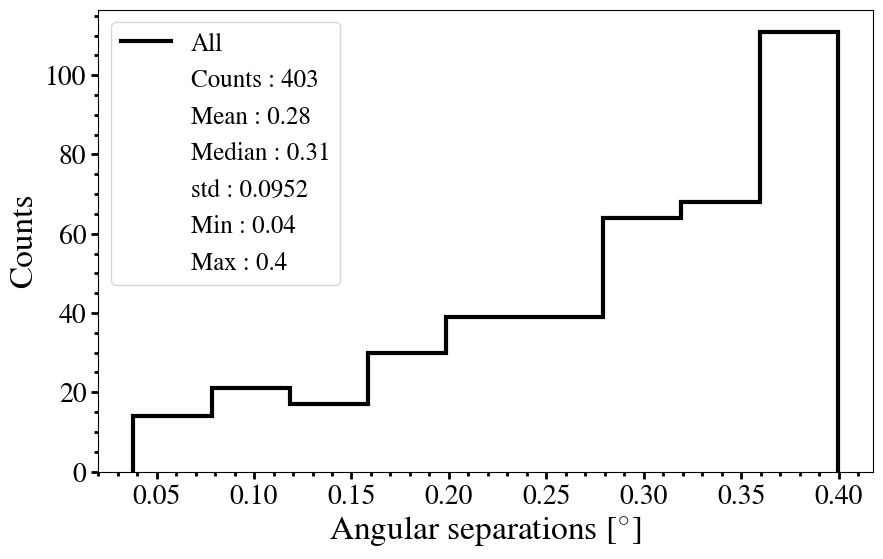

In [ ]:
from scipy import stats

plt.figure(figsize=(10, 6))

plt.hist(angular_sep_arr2, bins=np.linspace(np.nanmin(angular_sep_arr2), np.nanmax(angular_sep_arr2), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', linewidth=3,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'Angular separations [$^{\circ}$]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper left', fontsize=18)
plt.show()

In [ ]:
sep_dist_arr2 = np.tan(np.radians(angular_sep_arr2)) * 220. # pc
print(np.min(sep_dist_arr2), np.max(sep_dist_arr2))

stats_series = pd.DataFrame(sep_dist_arr2).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

0.1461427678094611 1.5343915106125798


,sep_distance
count,403.000000
mean,1.082435
std,0.365638
min,0.146143
25%,0.855003
50%,1.174680
75%,1.390334
max,1.534392


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

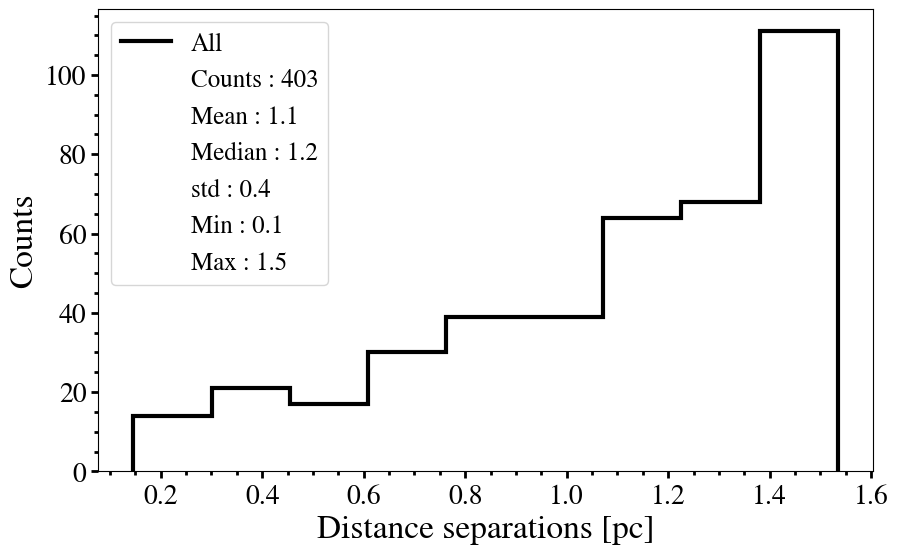

In [ ]:
from scipy import stats

plt.figure(figsize=(10, 6))

plt.hist(sep_dist_arr2, bins=np.linspace(np.nanmin(sep_dist_arr2), np.nanmax(sep_dist_arr2), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', linewidth=3,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'Distance separations [pc]', fontsize=24)
plt.ylabel(r'Counts', fontsize=24)

plt.legend(loc='upper left', fontsize=18)
plt.show()

In [ ]:
ki_ism_vlsr_obs_selected2 = ggdfc2['ki_ism_vlsr_obs']
ki_ism_avg_vlsr_obs2 = ggdfc2['ki_ism_avg_vlsr_obs']
emt_min_vlsrs2 = ggdfc2['emt_min_vlsr']
ki_ism_sig_vlsr_obs2 = ggdfc2['ki_ism_sig_vlsr_obs']

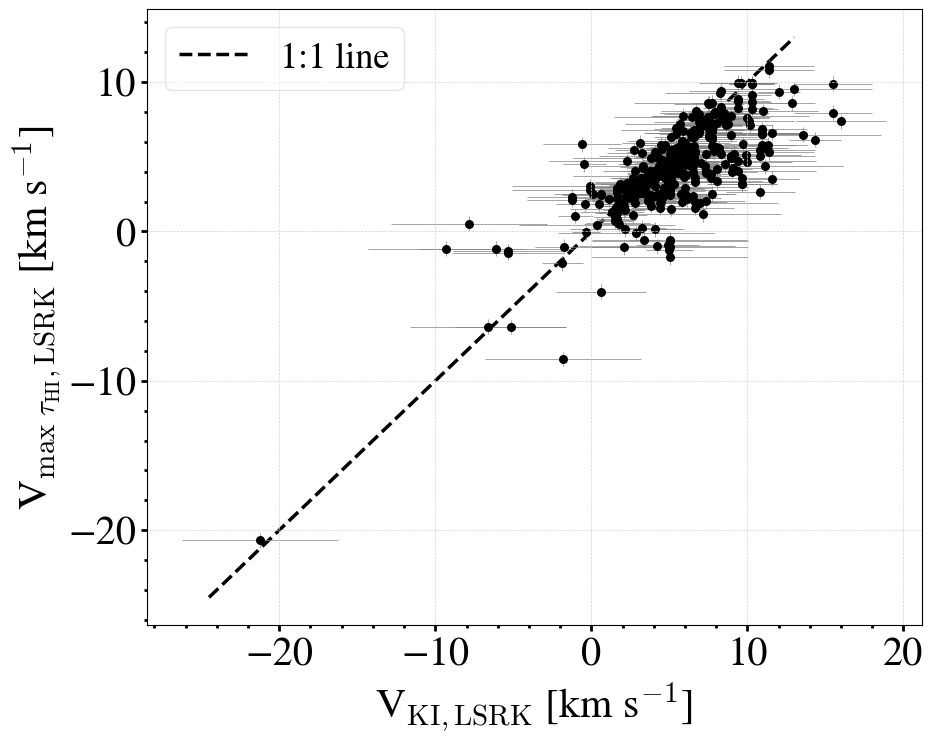

In [ ]:
# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.errorbar(ki_ism_vlsr_obs_selected2, emt_min_vlsrs2,
             xerr=ki_ism_sig_vlsr_obs2*(ki_ism_sig_vlsr_obs2>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')


ax.scatter(ki_ism_vlsr_obs_selected2, emt_min_vlsrs2, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'')

ax.plot([-24.5, 13.], [-24.5, 13.], c='k', ls='--', lw='2.5', zorder=-1, label='1:1 line')



ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(ki_ism_vlsr_obs_selected2, emt_min_vlsrs2)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.7711
P-value: 0.0000
P-value: 1.2641816555847336e-80


In [ ]:
# Calculate Spearman correlation coefficient
spearman_corr, p_value = stats.spearmanr(ki_ism_vlsr_obs_selected2, emt_min_vlsrs2)

print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.7461
P-value: 0.0000
P-value: 8.000854498911916e-73


In [ ]:
vlsrk_diff2 = (emt_min_vlsrs2 - ki_ism_vlsr_obs_selected2)
print(np.min(vlsrk_diff2), np.max(vlsrk_diff2))

-8.660640408655368 8.330505057427445


In [ ]:
stats_series = pd.DataFrame(vlsrk_diff2).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,403.000000
mean,-1.144230
std,2.324054
min,-8.660640
25%,-2.184460
50%,-0.660965
75%,0.078253
max,8.330505


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

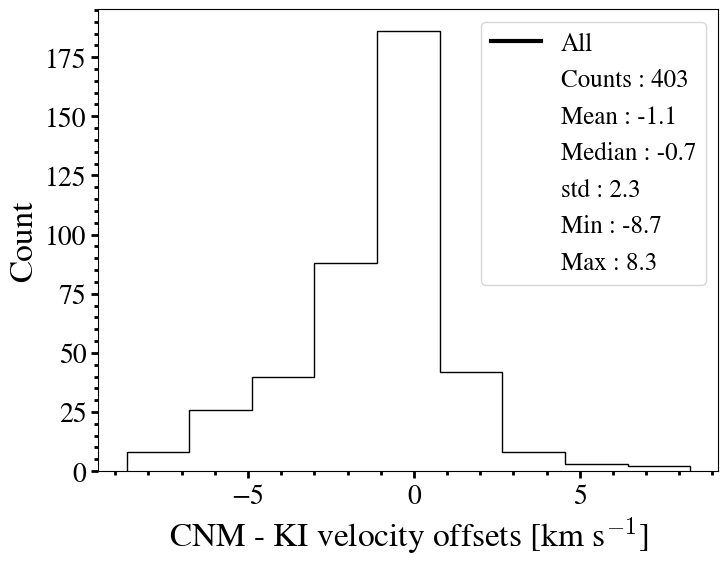

In [ ]:
from scipy import stats

plt.figure(figsize=(8, 6))

plt.hist(vlsrk_diff2, bins=np.linspace(np.nanmin(vlsrk_diff2), np.nanmax(vlsrk_diff2), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

plt.xlabel(r'CNM - KI velocity offsets [km s$^{-1}$]', fontsize=24)
plt.ylabel(r'Count', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

# Read matched stars within 0.75 pc

In [ ]:
gaskap_galah_csv_file = gaskap_hires_result_path / 'gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv'
print(gaskap_galah_csv_file)

ggdf = pd.read_csv(gaskap_galah_csv_file)
print(ggdf.shape)

/content/gdrive/MyDrive/Colab Notebooks/GASKAP/data/hires/results/gaskap_abs_galah_star_ki_ism_using_gaussfit_smaller_radii_0155.csv
(462, 21)


In [ ]:
current_ggdf = ggdf[ggdf['star_id'] > 0]

In [ ]:
print(100.*current_ggdf.shape[0]/ggdf.shape[0])

62.77056277056277


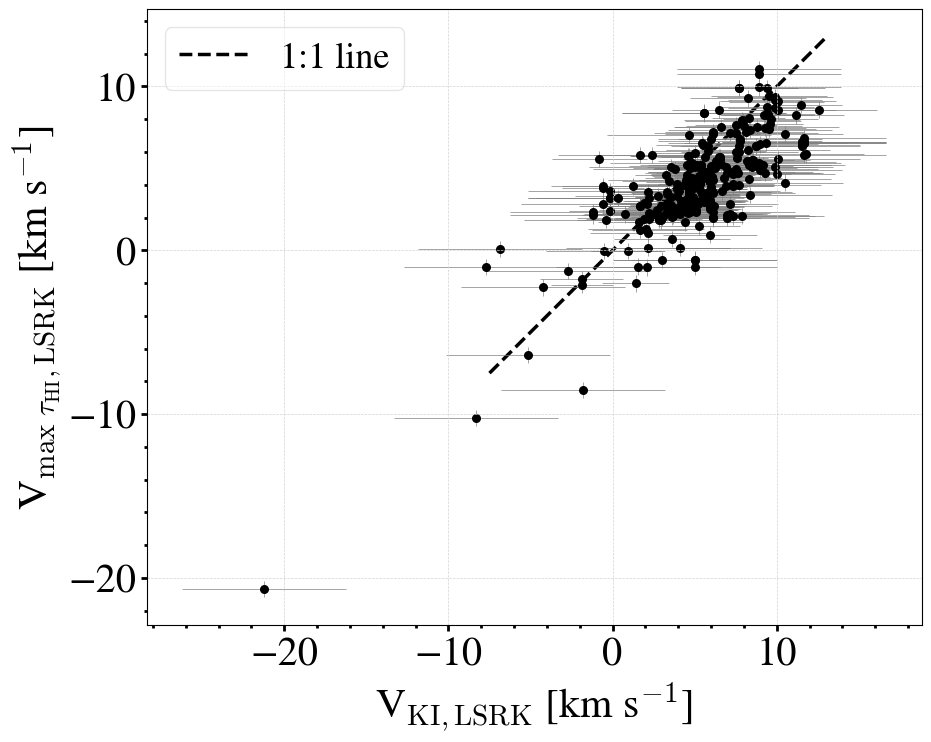

In [ ]:
ki_ism_vlsr_obs_selected = current_ggdf['ki_ism_vlsr_obs']
ki_ism_avg_vlsr_obs = current_ggdf['ki_ism_avg_vlsr_obs']
emt_min_vlsrs = current_ggdf['emt_min_vlsr']
ki_ism_sig_vlsr_obs = current_ggdf['ki_ism_sig_vlsr_obs']


# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.errorbar(ki_ism_vlsr_obs_selected, emt_min_vlsrs,
             xerr=ki_ism_sig_vlsr_obs*(ki_ism_sig_vlsr_obs>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')

ax.scatter(ki_ism_vlsr_obs_selected, emt_min_vlsrs, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'')

ax.plot([-7.5, 13.], [-7.5, 13.], c='k', ls='--', lw='2.5', zorder=-1, label='1:1 line')

ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)




ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)


print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.7878
P-value: 0.0000
P-value: 1.4369798998194799e-62


In [ ]:
# Calculate Spearman correlation coefficient
spearman_corr, p_value = stats.spearmanr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)

print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Spearman correlation coefficient: 0.7286
P-value: 0.0000
P-value: 2.975368683160055e-49


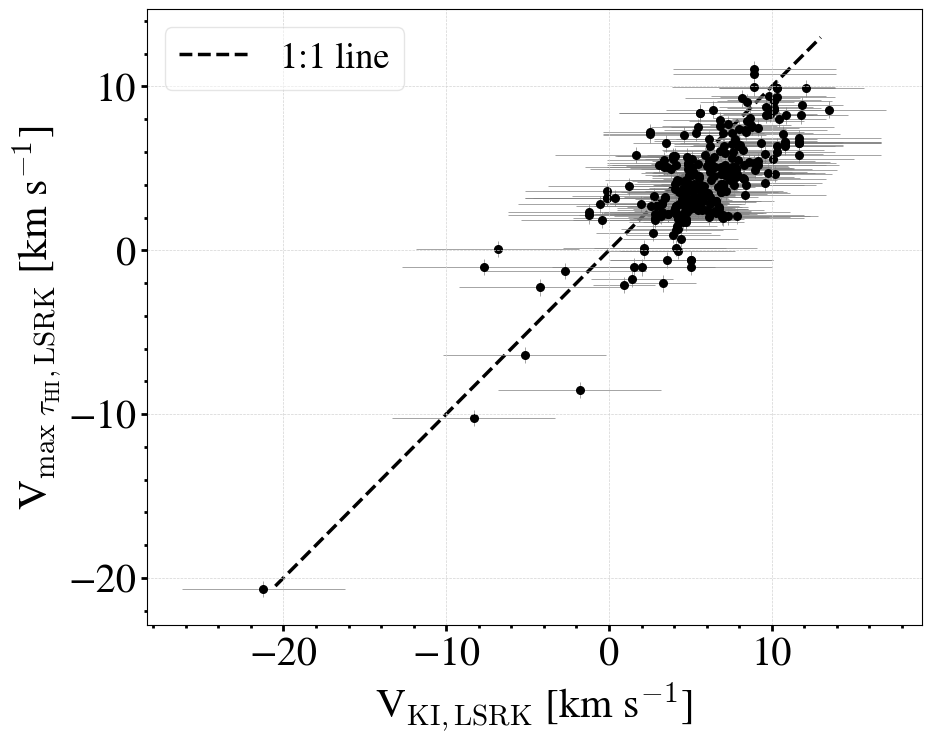

In [ ]:
# Plot
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)

ax.errorbar(ki_ism_avg_vlsr_obs, emt_min_vlsrs,
             xerr=ki_ism_sig_vlsr_obs*(ki_ism_sig_vlsr_obs>0.), yerr=0.5, zorder=1,
             ls='None', markersize=2,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='gray', elinewidth=0.5,
             label='')

ax.scatter(ki_ism_avg_vlsr_obs, emt_min_vlsrs, zorder=1, s=30, marker='o',
                 c='k',
                 label=f'')

ax.plot([-20.5, 13.], [-20.5, 13.], c='k', ls='--', lw='2.5', zorder=-1, label='1:1 line')

ax.set_ylabel(r'V$_\mathrm{max ~ \tau_\mathrm{HI}, LSRK}$ [km s$^{-1}$]', fontsize=30)
ax.set_xlabel(r'V$_\mathrm{KI, LSRK}$ [km s$^{-1}$]', fontsize=30, fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=29, pad=4)
ax.tick_params(axis='y', labelsize=29)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

ax.legend(loc='upper left', fancybox=True, framealpha=0.5, labelcolor='k', fontsize=26)


ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=1.8,
                    hspace=0.0
                    )

plt.show()

In [ ]:
vlsrk_diff = (emt_min_vlsrs - ki_ism_vlsr_obs_selected)
print(np.min(vlsrk_diff), np.max(vlsrk_diff))

-6.743917260143366 6.940484067718106


In [ ]:
stats_series = pd.DataFrame(vlsrk_diff).describe()
series_index = stats_series.index.to_list()
series_values = stats_series.values.flatten()
stats_series

,0
count,290.000000
mean,-1.270420
std,2.293127
min,-6.743917
25%,-2.637374
50%,-1.195797
75%,-0.020984
max,6.940484


In [ ]:
x_count = int(series_values[0])
x_mean = round(series_values[1], 1)
x_std = round(series_values[2], 1)
x_minval = round(series_values[3], 1)
x_maxval = round(series_values[-1], 1)
x_median = round(series_values[5], 1)
x_labels = ['Counts', 'Mean', 'Median', 'std', 'Min', 'Max']
x_stats_values = [x_count, x_mean, x_median, x_std, x_minval, x_maxval]

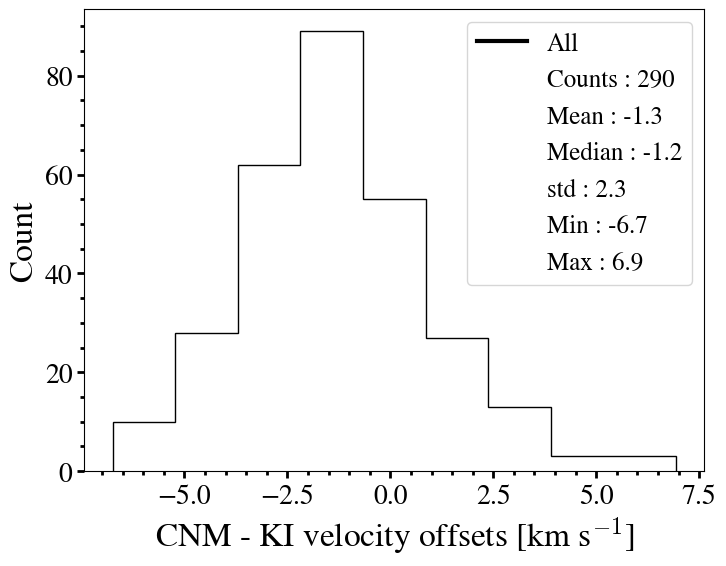

In [ ]:
from scipy import stats

plt.figure(figsize=(8, 6))

# sns.histplot(data=taucnm, bins=40, kde=False)
plt.hist(vlsrk_diff, bins=np.linspace(np.nanmin(vlsrk_diff), np.nanmax(vlsrk_diff), 10),
         density=False, color='k', histtype='step',
         alpha=1., ls='-', lw=50,
         label='')

ploti, = plt.plot([], [], 'k-', lw=3, label=f'All')
ploti.set_visible(True)

# ploti, = plt.plot([], [], 'g-', lw=3, label=r'With std of $\tau$ noise < 0.1')
# ploti.set_visible(True)

# ploti, = plt.plot([], [], 'r-', lw=3, label=r'With std of $\tau$ noise >= 0.1')
# ploti.set_visible(True)

# ploti, = plt.plot([], [], '', label=f'Number of sightlines: {-=}')
# ploti.set_visible(False)

for labeli,vali in zip(x_labels, x_stats_values):
    ploti, = plt.plot([], [], '', label=f"{labeli} : {vali}")
    ploti.set_visible(False)


plt.minorticks_on()
plt.tick_params(axis='x', labelsize=20, pad=4)
plt.tick_params(axis='y', labelsize=20)
plt.tick_params(which='both', width=2)
plt.tick_params(which='major', length=5)
plt.tick_params(which='minor', length=3)

# plt.title(f'Optical depth, sightlines decomposed: {ndet_total}, total N_CNM_components: {total_ncnm}')
plt.xlabel(r'CNM - KI velocity offsets [km s$^{-1}$]', fontsize=24)
plt.ylabel(r'Count', fontsize=24)

plt.legend(loc='upper right', fontsize=18)
plt.show()

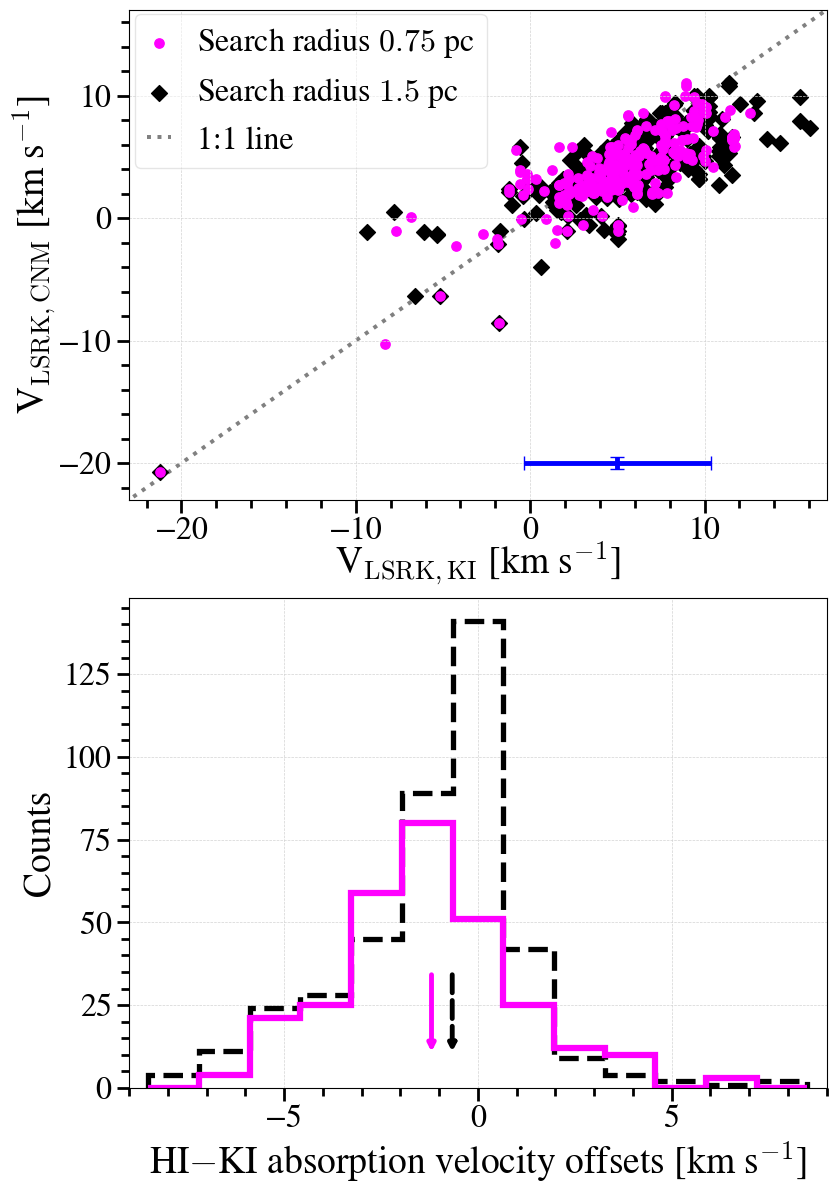

In [ ]:
confidence = 0.68
# Plot
fig = plt.figure(figsize=(9,14))

ax = plt.subplot(211)

ax.errorbar(ki_ism_vlsr_obs_selected, emt_min_vlsrs,
             xerr=0., yerr=0., zorder=-1,
             ls='None', markersize=4,
             markeredgecolor='lightgrey', markeredgewidth=1,
             ecolor='grey', elinewidth=0.5,
             label='')


ax.errorbar(5., -20,
             xerr=5.35, yerr=0.5, zorder=3,
             ls='None', markersize=4,
             markeredgecolor='b', markeredgewidth=1,
             ecolor='b', elinewidth=3.5, capsize=5,
             label='')

ax.scatter(ki_ism_vlsr_obs_selected, emt_min_vlsrs, zorder=1, s=45, marker='o',
                 c='magenta',
                 label=r'Search radius $0.75$ pc')
ax.scatter(ki_ism_vlsr_obs_selected2, emt_min_vlsrs2, zorder=0, s=65, marker='D',
                 c='k',
                 label=r'Search radius $1.5$ pc')

ax.plot([-23.25, 18.], [-23.25, 18.], c='gray', ls=':', lw='2.85', zorder=-1, label='1:1 line')

ax.set_ylabel(r'V$_\mathrm{LSRK, CNM}$ [km s$^{-1}$]', fontsize=27, labelpad=0.)
ax.set_xlabel(r'V$_\mathrm{LSRK, KI}$ [km s$^{-1}$]', fontsize=27, labelpad=-5., fontweight='normal')

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=23, pad=3)
ax.tick_params(axis='y', labelsize=23)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=6)

ax.set_xlim(-23., 17.)
ax.set_ylim(-23., 17.)

ax.legend(loc='upper left', bbox_to_anchor=(-0.015, 1.025), fancybox=True, framealpha=0.5, labelcolor='k', handlelength=0.75, fontsize=23)
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-1)






###
ax = plt.subplot(212)

ax.hist(vlsrk_diff2, bins=np.linspace(-8.5, 8.5, 14),
         density=False, color='k', histtype='step', linestyle='--', linewidth=3.8, label=r'')

ax.hist(vlsrk_diff, bins=np.linspace(-8.5, 8.5, 14),
         density=False, color='magenta', histtype='step', ls='-', linewidth=4.5, label='')


ploti, = ax.plot([], [], color='magenta', linestyle='-', lw=4.5, label=r'Search radius $0.75$ pc')
ploti.set_visible(True)

ploti, = ax.plot([], [], 'k--', lw=3.8, label=r'Search radius $1.5$ pc')
ploti.set_visible(True)


## Arrows for medians
med_val = np.median(vlsrk_diff)
med_val2 = np.median(vlsrk_diff2)
ax.annotate('', xy=(med_val, 10), xycoords='data', xytext=(med_val, 35), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='magenta', lw=3.5, ls='-'))
ax.annotate('', xy=(med_val2, 10), xycoords='data', xytext=(med_val2, 35), textcoords='data',
    arrowprops=dict(arrowstyle= '-|>', color='k', lw=3.5, ls='--'))

ax.set_ylabel(r'Counts', fontsize=27)
ax.set_xlabel(r'HI$-$KI absorption velocity offsets [km s$^{-1}$]', fontsize=27)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=23, pad=3)
ax.tick_params(axis='y', labelsize=23)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=9)
ax.tick_params(which='minor', length=6)

ax.set_xlim(-9., 9.)

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-1)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.,
                    hspace=0.2
                    )

plt.show()

In [ ]:
# Calculate Pearson correlation coefficient
pearson_corr, p_value = stats.pearsonr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)

print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")
print('')

# Calculate Spearman correlation coefficient
spearman_corr, p_value = stats.spearmanr(ki_ism_vlsr_obs_selected, emt_min_vlsrs)

print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.7878
P-value: 0.0000
P-value: 1.4369798998194799e-62

Spearman correlation coefficient: 0.7286
P-value: 0.0000
P-value: 2.975368683160055e-49


In [ ]:
# Null hypothesis: data come from N(0, sigma)
# You must specify sigma (measurement error width)
sigma = 5.3  # your typical measurement error
D, pval = stats.kstest(vlsrk_diff, 'norm', args=(0, sigma))

print("KS statistic:", D)
print("p-value:", pval)

KS statistic: 0.3056657004208032
p-value: 1.5127518430287307e-24


In [ ]:
from scipy import stats

# your data
sigma = 5.35 # 2.3 # 10.7 # 5.358000

# KS test vs N(0, sigma)
D, p = stats.kstest(vlsrk_diff2.values, 'norm', args=(0, sigma))

print("KS statistic:", D)
print("p-value:", p)


KS statistic: 0.3406189979948189
p-value: 3.110861077096122e-42
